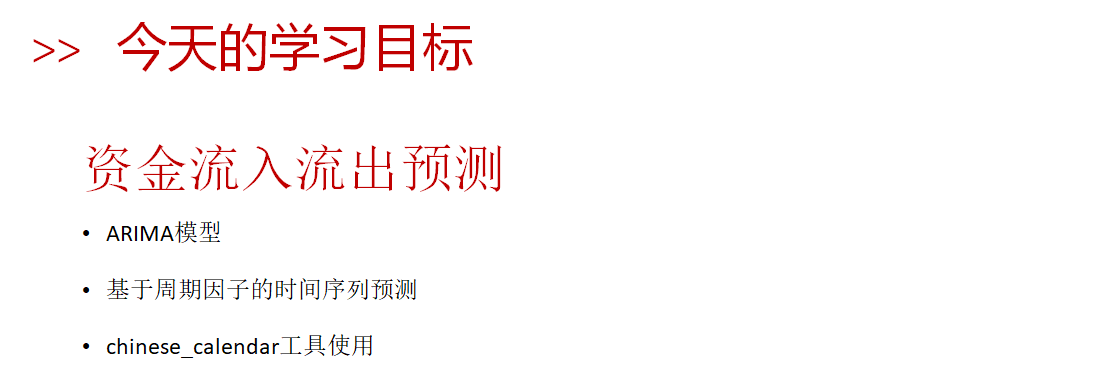

## 资金流入流出预测
#### Project：资金流入流出预测
+ https://tianchi.aliyun.com/competition/entrance/231573/information
+ 数据集一共包括4张表：用户基本信息数据、用户申购赎回数据、收益率表和银行间拆借利率表
+ 2.8万用户，284万行为数据，294天拆解利率，427天收益率
+ 2013-07-01到2014-08-31，预测2014年9月的申购和赎回

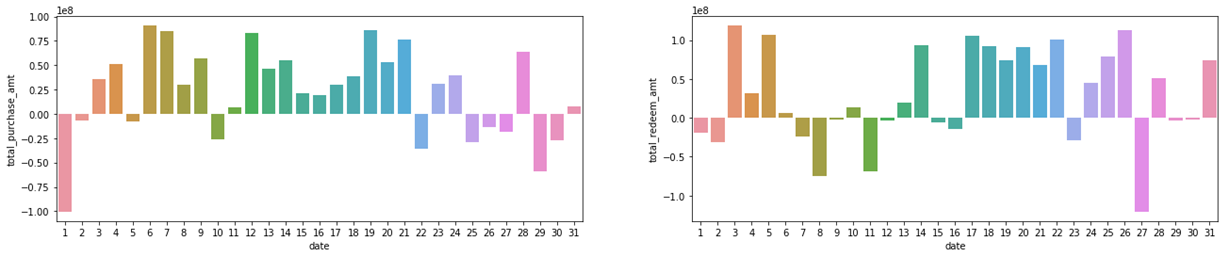

#### 项目有四张数据表
+ 用户信息表，user_profile_table
+ 用户申购赎回数据表 user_balance_table，这张表比较重要
+ 收益率表 mfd_day_share_interest
+ 上海银行间同业拆放利率表 mfd_bank_shibor

#### 满分：300分，要求：130分以上

## ARIMA

In [1]:
import pandas as pd
# 数据加载
# 日期格式：20140805，需要用 parse_dates 声明，如果不声明，会把它默认为数值格式
# read_csv中的日期格式解析 pd.read_csv('user_balance_table.csv', parse_dates = ['report_date'])
# 设置parse_dates参数，将时间字符串转换为日期格式
data = pd.read_csv('./user_balance_table.csv', parse_dates=['report_date'])
data

,user_id,report_date,tBalance,yBalance,total_purchase_amt,direct_purchase_amt,purchase_bal_amt,purchase_bank_amt,total_redeem_amt,consume_amt,transfer_amt,tftobal_amt,tftocard_amt,share_amt,category1,category2,category3,category4
0,1,2014-08-05,20385,20383,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN
1,1,2014-08-08,20391,20389,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN
2,1,2014-08-11,20397,20395,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN
3,1,2014-08-14,20403,20401,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN
4,1,2014-08-17,20409,20407,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2840416,28033,2014-08-25,550646,550585,61,0,0,0,0,0,0,0,0,61,NaN,NaN,NaN,NaN
2840417,28033,2014-08-31,525707,538147,60,0,0,0,12500,12500,0,0,0,60,0.0,0.0,0.0,12500.0
2840418,28033,2014-07-24,20487121,20484824,2297,0,0,0,0,0,0,0,0,2297,NaN,NaN,NaN,NaN
2840419,28033,2014-07-27,20462288,20491722,2298,0,0,0,31732,0,31732,0,31732,2298,NaN,NaN,NaN,NaN


In [2]:
# 同一天针对不同的用户，有多行
print(data['report_date'].nunique())

# 需要按照 report_date 进行聚合特征统计（total_purchase_amt ，total_redeem_amt）的sum
df = data.groupby(['report_date'])['total_purchase_amt', 'total_redeem_amt'].sum()
df

427


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """


,total_purchase_amt,total_redeem_amt
report_date,,
2013-07-01,32488348,5525022
2013-07-02,29037390,2554548
2013-07-03,27270770,5953867
2013-07-04,18321185,6410729
2013-07-05,11648749,2763587
...,...,...
2014-08-27,302194801,468164147
2014-08-28,245082751,297893861
2014-08-29,267554713,273756380


In [3]:
# 需要建立两个时间序列模型，数据单位为：分
# 提取 purchase
purchase = df[['total_purchase_amt']]
# 提取 redeem
redeem = df[['total_redeem_amt']]
purchase

,total_purchase_amt
report_date,
2013-07-01,32488348
2013-07-02,29037390
2013-07-03,27270770
2013-07-04,18321185
2013-07-05,11648749
...,...
2014-08-27,302194801
2014-08-28,245082751
2014-08-29,267554713


In [15]:
# pkl python对象，速度要比csv更快,任何python都可以pkl
purchase.to_pickle('./purchase.pkl')
redeem.to_pickle('./redeem.pkl')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  


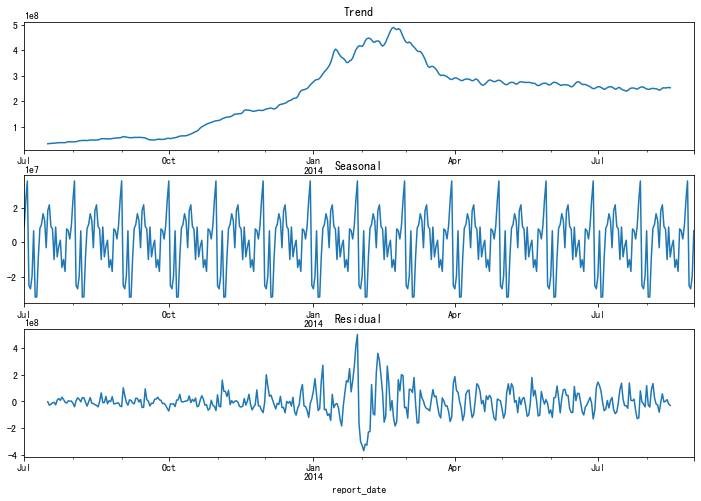

In [4]:
import matplotlib.pyplot as plt
import statsmodels.api as sm

# 对于指定时间范围的 data 进行可视化
def plot_stl(data):
    result = sm.tsa.seasonal_decompose(data, freq=30) # freq=30 按月为周期
    # trend, seasonal, residual
    fig = plt.figure(figsize=(12,8))
    ax1 = fig.add_subplot(3, 1, 1) # 3行1列的第一张图
    ax2 = fig.add_subplot(3, 1, 2)
    ax3 = fig.add_subplot(3, 1, 3)
    result.trend.plot(ax=ax1, title='Trend')
    result.seasonal.plot(ax=ax2, title='Seasonal')
    result.resid.plot(ax=ax3, title='Residual')
    
plot_stl(purchase)

In [5]:
from statsmodels.tsa.stattools import adfuller
t=adfuller(purchase)
t

(-1.5898802926313507,
 0.4886749751375928,
 18,
 408,
 {'1%': -3.446479704252724,
  '5%': -2.8686500930967354,
  '10%': -2.5705574627547096},
 15960.28197033403)

In [6]:
# DataFrame.diff()函数用来将数据进行某种移动之后与原数据进行比较得出的差异数据
diff1 = purchase.diff(1)
t=adfuller(diff1[1:])
t

(-7.947102224652343,
 3.198186862488185e-12,
 18,
 407,
 {'1%': -3.4465195891135845,
  '5%': -2.8686676281678634,
  '10%': -2.5705668101226085},
 15918.844657651942)

In [7]:
# 计算redeem的差分阶数
t=adfuller(redeem)
t

(-1.372413679828339,
 0.5954275877949474,
 13,
 413,
 {'1%': -3.4462831955497135,
  '5%': -2.8685636962704395,
  '10%': -2.5705114078759914},
 15816.780952766481)

In [8]:
# -1.372413679828339 大于 10%，不能拒绝H0，数据非平稳
diff2 = redeem.diff(1)
t=adfuller(diff2[1:])
t

(-11.69198690696884,
 1.6443717458497645e-21,
 12,
 413,
 {'1%': -3.4462831955497135,
  '5%': -2.8685636962704395,
  '10%': -2.5705114078759914},
 15779.04993673871)

In [9]:
from statsmodels.tsa.arima_model import ARIMA
# 选择合适的p,d,q
model = ARIMA(purchase,order=(7,1,5)).fit()
purchase_pred = model.predict('2014-09-01', '2014-09-30',typ='levels') # typ 反差分
purchase_pred

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


2014-09-01    3.310539e+08
2014-09-02    3.318762e+08
2014-09-03    3.338910e+08
2014-09-04    2.983191e+08
2014-09-05    2.407509e+08
2014-09-06    2.266140e+08
2014-09-07    2.435554e+08
2014-09-08    2.970865e+08
2014-09-09    3.321274e+08
2014-09-10    3.265197e+08
2014-09-11    2.916841e+08
2014-09-12    2.392702e+08
2014-09-13    2.253550e+08
2014-09-14    2.475289e+08
2014-09-15    2.950936e+08
2014-09-16    3.345010e+08
2014-09-17    3.280818e+08
2014-09-18    2.927099e+08
2014-09-19    2.448967e+08
2014-09-20    2.275711e+08
2014-09-21    2.530230e+08
2014-09-22    2.980719e+08
2014-09-23    3.366748e+08
2014-09-24    3.321948e+08
2014-09-25    2.947106e+08
2014-09-26    2.505384e+08
2014-09-27    2.318269e+08
2014-09-28    2.574471e+08
2014-09-29    3.025702e+08
2014-09-30    3.387019e+08
Freq: D, dtype: float64

In [11]:
model.aic

16669.646033929606

In [10]:
# 选择合适的p,d,q
model2 = ARIMA(redeem,order=(7,1,5)).fit()
redeem_pred = model2.predict('2014-09-01', '2014-09-30', typ='levels') # typ 反差分，不加typ,结果和typ='linear'相同
redeem_pred

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2014-09-01    3.169090e+08
2014-09-02    3.372455e+08
2014-09-03    3.632442e+08
2014-09-04    3.074694e+08
2014-09-05    2.628057e+08
2014-09-06    2.258706e+08
2014-09-07    2.592158e+08
2014-09-08    3.115468e+08
2014-09-09    3.477437e+08
2014-09-10    3.562431e+08
2014-09-11    3.092719e+08
2014-09-12    2.598512e+08
2014-09-13    2.339112e+08
2014-09-14    2.578186e+08
2014-09-15    3.125493e+08
2014-09-16    3.537239e+08
2014-09-17    3.573622e+08
2014-09-18    3.146179e+08
2014-09-19    2.626592e+08
2014-09-20    2.387440e+08
2014-09-21    2.616172e+08
2014-09-22    3.157165e+08
2014-09-23    3.588117e+08
2014-09-24    3.611535e+08
2014-09-25    3.197931e+08
2014-09-26    2.672031e+08
2014-09-27    2.432839e+08
2014-09-28    2.661170e+08
2014-09-29    3.197114e+08
2014-09-30    3.635485e+08
Freq: D, dtype: float64

In [12]:
model2.aic

16519.896275849063

In [13]:
result = pd.DataFrame()
result['report_date'] = purchase_pred.index
result['purchase'] = purchase_pred.values
result['redeem'] = redeem_pred.values

# 转换日期格式
def f(x):
    return str(x).replace('-', '')[0:8]

result['report_date'] = result['report_date'].apply(f)
result

,report_date,purchase,redeem
0,20140901,3.310539e+08,3.169090e+08
1,20140902,3.318762e+08,3.372455e+08
2,20140903,3.338910e+08,3.632442e+08
3,20140904,2.983191e+08,3.074694e+08
4,20140905,2.407509e+08,2.628057e+08
5,20140906,2.266140e+08,2.258706e+08
6,20140907,2.435554e+08,2.592158e+08
7,20140908,2.970865e+08,3.115468e+08
8,20140909,3.321274e+08,3.477437e+08
9,20140910,3.265197e+08,3.562431e+08


In [14]:
result.to_csv('baseline_arima.csv', header=None, index=False)
result

,report_date,purchase,redeem
0,20140901,3.310539e+08,3.169090e+08
1,20140902,3.318762e+08,3.372455e+08
2,20140903,3.338910e+08,3.632442e+08
3,20140904,2.983191e+08,3.074694e+08
4,20140905,2.407509e+08,2.628057e+08
5,20140906,2.266140e+08,2.258706e+08
6,20140907,2.435554e+08,2.592158e+08
7,20140908,2.970865e+08,3.115468e+08
8,20140909,3.321274e+08,3.477437e+08
9,20140910,3.265197e+08,3.562431e+08


## Prophrt

In [29]:
import pickle

# 数据加载
with open('./purchase.pkl', 'rb') as file:
    purchase = pickle.load(file)
    
with open('./redeem.pkl', 'rb') as file:
    redeem = pickle.load(file)
    
purchase

,total_purchase_amt
report_date,
2013-07-01,32488348
2013-07-02,29037390
2013-07-03,27270770
2013-07-04,18321185
2013-07-05,11648749
...,...
2014-08-27,302194801
2014-08-28,245082751
2014-08-29,267554713


In [30]:
purchase = purchase.reset_index()
purchase.columns = ['ds', 'y']
purchase

,ds,y
0,2013-07-01,32488348
1,2013-07-02,29037390
2,2013-07-03,27270770
3,2013-07-04,18321185
4,2013-07-05,11648749
...,...,...
422,2014-08-27,302194801
423,2014-08-28,245082751
424,2014-08-29,267554713
425,2014-08-30,199708772


In [21]:
from fbprophet import Prophet

# 创建 Prophet 模型
model = Prophet(yearly_seasonality=True, seasonality_prior_scale=0.1) # seasonality_prior_scale默认10
model.fit(purchase)

# 预测未来一个月，9月份有30天 
future = model.make_future_dataframe(periods=30)
future

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds
0,2013-07-01
1,2013-07-02
2,2013-07-03
3,2013-07-04
4,2013-07-05
...,...
452,2014-09-26
453,2014-09-27
454,2014-09-28
455,2014-09-29


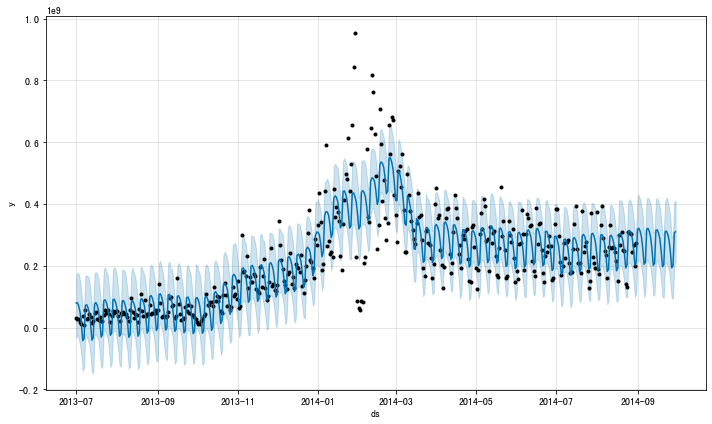

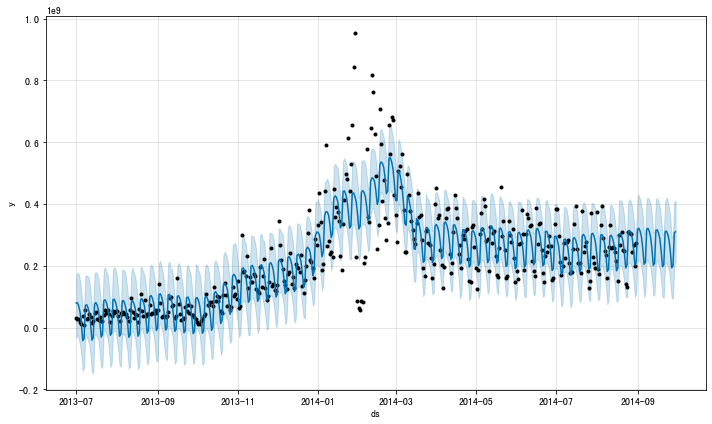

In [22]:
purchase_pred = model.predict(future)
model.plot(purchase_pred)

In [23]:
purchase_pred

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2013-07-01,1.045388e+08,-3.354305e+07,1.711366e+08,1.045388e+08,1.045388e+08,-2.516043e+07,-2.516043e+07,-2.516043e+07,4.494690e+07,4.494690e+07,4.494690e+07,-7.010733e+07,-7.010733e+07,-7.010733e+07,0.0,0.0,0.0,7.937839e+07
1,2013-07-02,1.051214e+08,-2.200396e+07,1.778069e+08,1.051214e+08,1.051214e+08,-2.499094e+07,-2.499094e+07,-2.499094e+07,4.767355e+07,4.767355e+07,4.767355e+07,-7.266449e+07,-7.266449e+07,-7.266449e+07,0.0,0.0,0.0,8.013048e+07
2,2013-07-03,1.057040e+08,-3.644757e+07,1.737096e+08,1.057040e+08,1.057040e+08,-3.725560e+07,-3.725560e+07,-3.725560e+07,3.774499e+07,3.774499e+07,3.774499e+07,-7.500059e+07,-7.500059e+07,-7.500059e+07,0.0,0.0,0.0,6.844844e+07
3,2013-07-04,1.062866e+08,-5.702187e+07,1.495985e+08,1.062866e+08,1.062866e+08,-5.755997e+07,-5.755997e+07,-5.755997e+07,1.952318e+07,1.952318e+07,1.952318e+07,-7.708315e+07,-7.708315e+07,-7.708315e+07,0.0,0.0,0.0,4.872667e+07
4,2013-07-05,1.068693e+08,-8.950443e+07,1.101887e+08,1.068693e+08,1.068693e+08,-9.679875e+07,-9.679875e+07,-9.679875e+07,-1.791231e+07,-1.791231e+07,-1.791231e+07,-7.888644e+07,-7.888644e+07,-7.888644e+07,0.0,0.0,0.0,1.007050e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
452,2014-09-26,3.678775e+08,1.428809e+08,3.525237e+08,3.678775e+08,3.678775e+08,-1.224916e+08,-1.224916e+08,-1.224916e+08,-1.791231e+07,-1.791231e+07,-1.791231e+07,-1.045793e+08,-1.045793e+08,-1.045793e+08,0.0,0.0,0.0,2.453859e+08
453,2014-09-27,3.684601e+08,9.513892e+07,2.917040e+08,3.684601e+08,3.684601e+08,-1.750847e+08,-1.750847e+08,-1.750847e+08,-6.960120e+07,-6.960120e+07,-6.960120e+07,-1.054835e+08,-1.054835e+08,-1.054835e+08,0.0,0.0,0.0,1.933754e+08
454,2014-09-28,3.690427e+08,9.556198e+07,3.014711e+08,3.690427e+08,3.690427e+08,-1.686998e+08,-1.686998e+08,-1.686998e+08,-6.237510e+07,-6.237510e+07,-6.237510e+07,-1.063247e+08,-1.063247e+08,-1.063247e+08,0.0,0.0,0.0,2.003429e+08
455,2014-09-29,3.696253e+08,2.031546e+08,4.077976e+08,3.696253e+08,3.696253e+08,-6.214775e+07,-6.214775e+07,-6.214775e+07,4.494690e+07,4.494690e+07,4.494690e+07,-1.070946e+08,-1.070946e+08,-1.070946e+08,0.0,0.0,0.0,3.074776e+08


In [36]:
# 找到prophet预测的 9月份的 purchase
purchase2 = purchase_pred[purchase_pred['ds']>='2014-09-01'][['ds', 'yhat']]

In [37]:
purchase2

,ds,yhat
427,2014-09-01,3.181871e+08
428,2014-09-02,3.214351e+08
429,2014-09-03,3.118692e+08
430,2014-09-04,2.938549e+08
431,2014-09-05,2.564787e+08
432,2014-09-06,2.047101e+08
433,2014-09-07,2.117294e+08
434,2014-09-08,3.187307e+08
435,2014-09-09,3.210375e+08
436,2014-09-10,3.106051e+08


In [31]:
redeem

,total_redeem_amt
report_date,
2013-07-01,5525022
2013-07-02,2554548
2013-07-03,5953867
2013-07-04,6410729
2013-07-05,2763587
...,...
2014-08-27,468164147
2014-08-28,297893861
2014-08-29,273756380


In [32]:
redeem = redeem.reset_index()
redeem.columns = ['ds', 'y']
redeem

,ds,y
0,2013-07-01,5525022
1,2013-07-02,2554548
2,2013-07-03,5953867
3,2013-07-04,6410729
4,2013-07-05,2763587
...,...,...
422,2014-08-27,468164147
423,2014-08-28,297893861
424,2014-08-29,273756380
425,2014-08-30,196374134


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


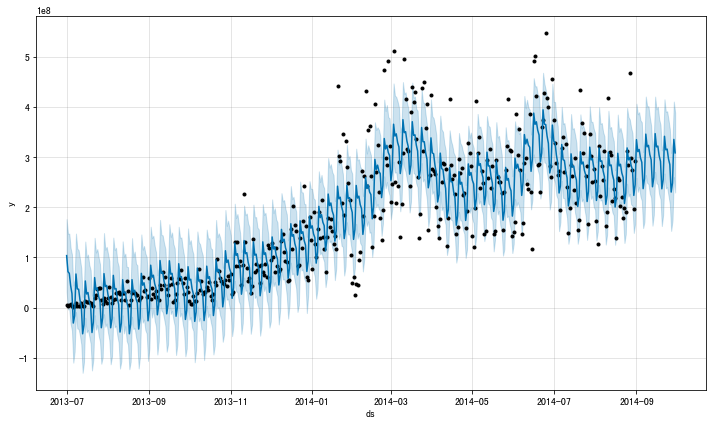

In [33]:
# 创建 Prophet 模型
model2 = Prophet(yearly_seasonality=True, seasonality_prior_scale=0.1)
model2.fit(redeem)

# 预测未来一个月，9月份有30天 
future2 = model2.make_future_dataframe(periods=30)
redeem_pred = model2.predict(future2)
model2.plot(redeem_pred)

redeem2 = redeem_pred[redeem_pred['ds']>='2014-09-01'][['ds', 'yhat']]

In [34]:
redeem2

,ds,yhat
427,2014-09-01,3.351325e+08
428,2014-09-02,3.111943e+08
429,2014-09-03,3.155245e+08
430,2014-09-04,2.987075e+08
431,2014-09-05,2.898158e+08
432,2014-09-06,2.372870e+08
433,2014-09-07,2.573634e+08
434,2014-09-08,3.461633e+08
435,2014-09-09,3.208417e+08
436,2014-09-10,3.237268e+08


In [38]:
# 合并结果
result = pd.DataFrame()
result['ds'] = purchase2.ds
result['purchase'] = purchase2.yhat
result['redeem'] = redeem2.yhat
result

,ds,purchase,redeem
427,2014-09-01,3.181871e+08,3.351325e+08
428,2014-09-02,3.214351e+08,3.111943e+08
429,2014-09-03,3.118692e+08,3.155245e+08
430,2014-09-04,2.938549e+08,2.987075e+08
431,2014-09-05,2.564787e+08,2.898158e+08
432,2014-09-06,2.047101e+08,2.372870e+08
433,2014-09-07,2.117294e+08,2.573634e+08
434,2014-09-08,3.187307e+08,3.461633e+08
435,2014-09-09,3.210375e+08,3.208417e+08
436,2014-09-10,3.106051e+08,3.237268e+08


In [39]:
# 转换日期格式
# def f(x):
#     return str(x).replace('-', '')[0:8]

# result['ds'] = result['ds'].apply(f)

result['ds'] = result['ds'].apply(lambda x:str(x).replace('-', '')[0:8])
result

,ds,purchase,redeem
427,20140901,3.181871e+08,3.351325e+08
428,20140902,3.214351e+08,3.111943e+08
429,20140903,3.118692e+08,3.155245e+08
430,20140904,2.938549e+08,2.987075e+08
431,20140905,2.564787e+08,2.898158e+08
432,20140906,2.047101e+08,2.372870e+08
433,20140907,2.117294e+08,2.573634e+08
434,20140908,3.187307e+08,3.461633e+08
435,20140909,3.210375e+08,3.208417e+08
436,20140910,3.106051e+08,3.237268e+08


In [40]:
result.to_csv('baseline_prophet.csv', header=None, index=False)

#### 提交结果
+ arima 一百多分
+ prophet 九十多分

## 模型融合
+ 按照提交结果取权重进行融合
+ 取二者的较大值 or 较小值

In [41]:
# 数据加载
arima_result = pd.read_csv('./baseline_arima.csv', header=None)
prophet_result = pd.read_csv('./baseline_prophet.csv', header=None)
prophet_result

,0,1,2
0,20140901,3.181871e+08,3.351325e+08
1,20140902,3.214351e+08,3.111943e+08
2,20140903,3.118692e+08,3.155245e+08
3,20140904,2.938549e+08,2.987075e+08
4,20140905,2.564787e+08,2.898158e+08
5,20140906,2.047101e+08,2.372870e+08
6,20140907,2.117294e+08,2.573634e+08
7,20140908,3.187307e+08,3.461633e+08
8,20140909,3.210375e+08,3.208417e+08
9,20140910,3.106051e+08,3.237268e+08


In [44]:
arima_result.columns = ['ds', 'purchase1', 'redeem1']
prophet_result.columns = ['ds', 'purchase2', 'redeem2']

In [45]:
arima_result

,ds,purchase1,redeem1
0,20140901,3.310539e+08,3.169090e+08
1,20140902,3.318762e+08,3.372455e+08
2,20140903,3.338910e+08,3.632442e+08
3,20140904,2.983191e+08,3.074694e+08
4,20140905,2.407509e+08,2.628057e+08
5,20140906,2.266140e+08,2.258706e+08
6,20140907,2.435554e+08,2.592158e+08
7,20140908,2.970865e+08,3.115468e+08
8,20140909,3.321274e+08,3.477437e+08
9,20140910,3.265197e+08,3.562431e+08


In [48]:
df = arima_result.merge(prophet_result, on='ds', how='left')
df

,ds,purchase1,redeem1,purchase2,redeem2
0,20140901,3.310539e+08,3.169090e+08,3.181871e+08,3.351325e+08
1,20140902,3.318762e+08,3.372455e+08,3.214351e+08,3.111943e+08
2,20140903,3.338910e+08,3.632442e+08,3.118692e+08,3.155245e+08
3,20140904,2.983191e+08,3.074694e+08,2.938549e+08,2.987075e+08
4,20140905,2.407509e+08,2.628057e+08,2.564787e+08,2.898158e+08
5,20140906,2.266140e+08,2.258706e+08,2.047101e+08,2.372870e+08
6,20140907,2.435554e+08,2.592158e+08,2.117294e+08,2.573634e+08
7,20140908,2.970865e+08,3.115468e+08,3.187307e+08,3.461633e+08
8,20140909,3.321274e+08,3.477437e+08,3.210375e+08,3.208417e+08
9,20140910,3.265197e+08,3.562431e+08,3.106051e+08,3.237268e+08


In [49]:
# 按照提交结果取权重进行融合
df['purchase'] = 0.6*df['purchase1'] + 0.4*df['purchase2']
df['redeem'] = 0.6*df['redeem1'] + 0.4*df['redeem2']
df

,ds,purchase1,redeem1,purchase2,redeem2,purchase,redeem
0,20140901,3.310539e+08,3.169090e+08,3.181871e+08,3.351325e+08,3.259072e+08,3.241984e+08
1,20140902,3.318762e+08,3.372455e+08,3.214351e+08,3.111943e+08,3.276998e+08,3.268250e+08
2,20140903,3.338910e+08,3.632442e+08,3.118692e+08,3.155245e+08,3.250823e+08,3.441563e+08
3,20140904,2.983191e+08,3.074694e+08,2.938549e+08,2.987075e+08,2.965335e+08,3.039646e+08
4,20140905,2.407509e+08,2.628057e+08,2.564787e+08,2.898158e+08,2.470420e+08,2.736098e+08
5,20140906,2.266140e+08,2.258706e+08,2.047101e+08,2.372870e+08,2.178524e+08,2.304372e+08
6,20140907,2.435554e+08,2.592158e+08,2.117294e+08,2.573634e+08,2.308250e+08,2.584748e+08
7,20140908,2.970865e+08,3.115468e+08,3.187307e+08,3.461633e+08,3.057442e+08,3.253934e+08
8,20140909,3.321274e+08,3.477437e+08,3.210375e+08,3.208417e+08,3.276914e+08,3.369829e+08
9,20140910,3.265197e+08,3.562431e+08,3.106051e+08,3.237268e+08,3.201539e+08,3.432366e+08


In [50]:
df[['ds', 'purchase', 'redeem']].to_csv('./baseline_ensemble.csv', header=None, index=False)

#### 提交结果
+ 100.0590

In [51]:
# 选取结果的较大值
for index, row in df.iterrows():
    df.loc[index, 'purchase'] = max(row['purchase1'], row['purchase2'])
    df.loc[index, 'redeem'] = max(row['redeem1'], row['redeem2'])
df

,ds,purchase1,redeem1,purchase2,redeem2,purchase,redeem
0,20140901,3.310539e+08,3.169090e+08,3.181871e+08,3.351325e+08,3.310539e+08,3.351325e+08
1,20140902,3.318762e+08,3.372455e+08,3.214351e+08,3.111943e+08,3.318762e+08,3.372455e+08
2,20140903,3.338910e+08,3.632442e+08,3.118692e+08,3.155245e+08,3.338910e+08,3.632442e+08
3,20140904,2.983191e+08,3.074694e+08,2.938549e+08,2.987075e+08,2.983191e+08,3.074694e+08
4,20140905,2.407509e+08,2.628057e+08,2.564787e+08,2.898158e+08,2.564787e+08,2.898158e+08
5,20140906,2.266140e+08,2.258706e+08,2.047101e+08,2.372870e+08,2.266140e+08,2.372870e+08
6,20140907,2.435554e+08,2.592158e+08,2.117294e+08,2.573634e+08,2.435554e+08,2.592158e+08
7,20140908,2.970865e+08,3.115468e+08,3.187307e+08,3.461633e+08,3.187307e+08,3.461633e+08
8,20140909,3.321274e+08,3.477437e+08,3.210375e+08,3.208417e+08,3.321274e+08,3.477437e+08
9,20140910,3.265197e+08,3.562431e+08,3.106051e+08,3.237268e+08,3.265197e+08,3.562431e+08


In [52]:
df[['ds', 'purchase', 'redeem']].to_csv('./baseline_ensemble2.csv', header=None, index=False)

#### 提交结果
+ 99.8068

In [55]:
# 选取结果的较小值
for index, row in df.iterrows():
    df.loc[index, 'purchase'] = min(row['purchase1'], row['purchase2'])
    df.loc[index, 'redeem'] = min(row['redeem1'], row['redeem2'])
df

,ds,purchase1,redeem1,purchase2,redeem2,purchase,redeem
0,20140901,3.310539e+08,3.169090e+08,3.181871e+08,3.351325e+08,3.181871e+08,3.169090e+08
1,20140902,3.318762e+08,3.372455e+08,3.214351e+08,3.111943e+08,3.214351e+08,3.111943e+08
2,20140903,3.338910e+08,3.632442e+08,3.118692e+08,3.155245e+08,3.118692e+08,3.155245e+08
3,20140904,2.983191e+08,3.074694e+08,2.938549e+08,2.987075e+08,2.938549e+08,2.987075e+08
4,20140905,2.407509e+08,2.628057e+08,2.564787e+08,2.898158e+08,2.407509e+08,2.628057e+08
5,20140906,2.266140e+08,2.258706e+08,2.047101e+08,2.372870e+08,2.047101e+08,2.258706e+08
6,20140907,2.435554e+08,2.592158e+08,2.117294e+08,2.573634e+08,2.117294e+08,2.573634e+08
7,20140908,2.970865e+08,3.115468e+08,3.187307e+08,3.461633e+08,2.970865e+08,3.115468e+08
8,20140909,3.321274e+08,3.477437e+08,3.210375e+08,3.208417e+08,3.210375e+08,3.208417e+08
9,20140910,3.265197e+08,3.562431e+08,3.106051e+08,3.237268e+08,3.106051e+08,3.237268e+08


In [54]:
df[['ds', 'purchase', 'redeem']].to_csv('./baseline_ensemble3.csv', header=None, index=False)

#### 提交结果
+ 101.5570
+ 取两者最小，分数最高

#### 绘制结果

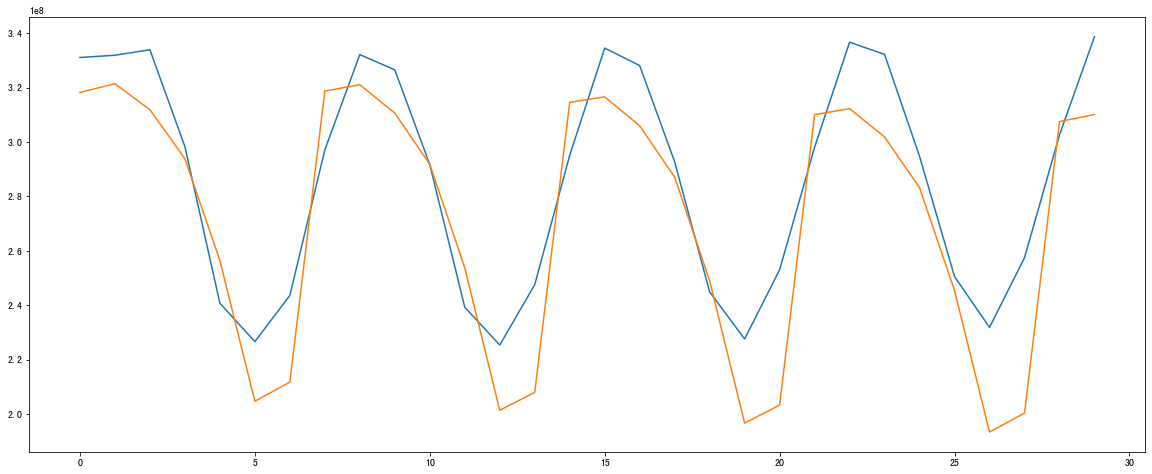

In [57]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,8))
plt.plot(arima_result['purchase1'])
plt.plot(prophet_result['purchase2'])
# date_range = pd.date_range('2014-09-01', '2014-09-30')
# plt.xticks(date_range, rotation=90)
# plt.show()

#### Thinking：模型预测准确性如何？
+ 1）过于简单，实际情况并不是
+ 2）周一到周日的特征规律没有利用
+ 3）没有考虑特殊时间，比如节日，利率波动节点

In [58]:
import pickle

# 数据加载
with open('./purchase.pkl', 'rb') as file:
    purchase = pickle.load(file)
purchase = purchase.reset_index()
purchase

# with open('./redeem.pkl', 'rb') as file:
#     redeem = pickle.load(file)

,report_date,total_purchase_amt
0,2013-07-01,32488348
1,2013-07-02,29037390
2,2013-07-03,27270770
3,2013-07-04,18321185
4,2013-07-05,11648749
...,...,...
422,2014-08-27,302194801
423,2014-08-28,245082751
424,2014-08-29,267554713
425,2014-08-30,199708772


In [59]:
purchase['report_date'] = pd.to_datetime(purchase['report_date'])
purchase['weekday'] = purchase['report_date'].dt.weekday
purchase

,report_date,total_purchase_amt,weekday
0,2013-07-01,32488348,0
1,2013-07-02,29037390,1
2,2013-07-03,27270770,2
3,2013-07-04,18321185,3
4,2013-07-05,11648749,4
...,...,...,...
422,2014-08-27,302194801,2
423,2014-08-28,245082751,3
424,2014-08-29,267554713,4
425,2014-08-30,199708772,5


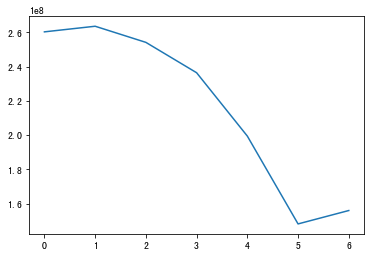

In [60]:
weekday_df = purchase.groupby(['weekday'])['total_purchase_amt'].mean()
plt.plot(weekday_df)

#### 上图可见（0-周一，1-周二，以此类推）
+ 周一周二存钱比较多，前半周存钱比较多，后半周存期比较少
+ 原因：周五，周六，周日三天 首次显示收益时间相隔比较久
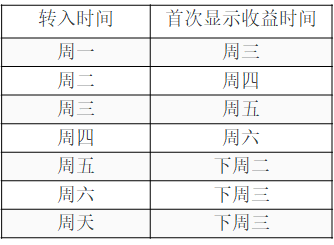

#### 时间序列规则：
###### 选择特征   可以用简单的统计量来作为特征，从中提取出有用的信息
+ 1）中位数：居于中间位置的数，较为稳健
+ 2）均值：当分布符合正态分布时，可以代表整体特征
+ 3）临近数据：离待测数据越近的数据对其影响越大

###### 基于周期因子的时间序列预测
+ 很多数据都具有明显的周期性，比如客流量，支付等
+ 需要确定周期长度，比如一周7天，一个月30天，结合STL分解 (Seasonal and Trend decomposition) 观察周期变化，缺点是没有考虑到节假日、突发事件等情况

###### 基于周期因子的时间序列预测
+ 假设给任务是根据前三周的数据预测第四周每天的客流量
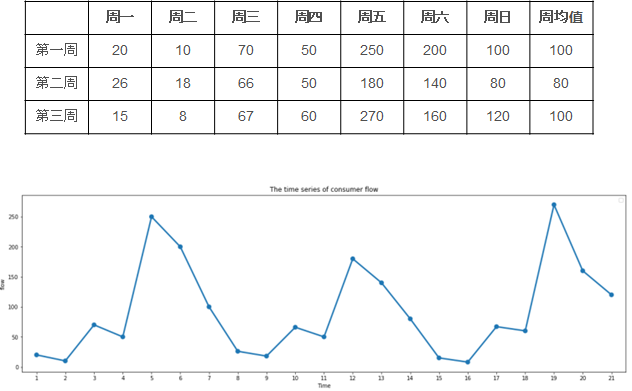

+ Step 1，获得周期因子（weekday）

> 获得星期几的均值，再除以整体均值

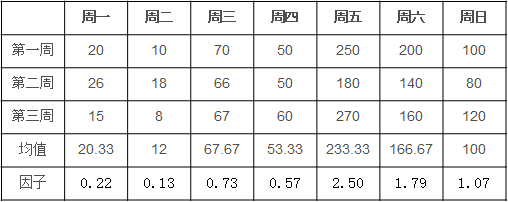

+ Step 2，计算base

+ Step3，使用base * 周期因子进行预测

> 假设base=100，可以得到第四周的客流量

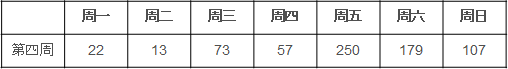

###### 预测下个月每一天的情况：

> 如果想预测下个月每天的流量情况，可以基于每月的规律（1-30号的平均流量）* 周期因子

+ Step1，计算周期因子（weekday）
+ Step2，计算每日（1号-30号）均值，即1号的平均流量，2号的平均流量 …
+ Step3，统计星期几（weekday）在每日（day）出现的频次
+ Step4，基于周期因子获得加权均值，得到每日的base（去掉周期因子的影响）
+ Step5，根据每日的base和周期因子进行预测

## rule_based

#### 基于周期因子，预测9月份的 purchase 和 redeem

In [61]:
import pandas as pd
import pickle

# 数据加载
with open('./purchase.pkl', 'rb') as file:
    purchase = pickle.load(file)
purchase = purchase.reset_index()

with open('./redeem.pkl', 'rb') as file:
    redeem = pickle.load(file)
redeem = redeem.reset_index()

purchase

,report_date,total_purchase_amt
0,2013-07-01,32488348
1,2013-07-02,29037390
2,2013-07-03,27270770
3,2013-07-04,18321185
4,2013-07-05,11648749
...,...,...
422,2014-08-27,302194801
423,2014-08-28,245082751
424,2014-08-29,267554713
425,2014-08-30,199708772


In [62]:
purchase['report_date'] = pd.to_datetime(purchase['report_date'])
purchase['day'] = purchase['report_date'].dt.day
purchase['weekday'] = purchase['report_date'].dt.weekday
purchase

,report_date,total_purchase_amt,day,weekday
0,2013-07-01,32488348,1,0
1,2013-07-02,29037390,2,1
2,2013-07-03,27270770,3,2
3,2013-07-04,18321185,4,3
4,2013-07-05,11648749,5,4
...,...,...,...,...
422,2014-08-27,302194801,27,2
423,2014-08-28,245082751,28,3
424,2014-08-29,267554713,29,4
425,2014-08-30,199708772,30,5


In [63]:
redeem['report_date'] = pd.to_datetime(redeem['report_date'])
redeem['day'] = redeem['report_date'].dt.day
redeem['weekday'] = redeem['report_date'].dt.weekday
redeem

,report_date,total_redeem_amt,day,weekday
0,2013-07-01,5525022,1,0
1,2013-07-02,2554548,2,1
2,2013-07-03,5953867,3,2
3,2013-07-04,6410729,4,3
4,2013-07-05,2763587,5,4
...,...,...,...,...
422,2014-08-27,468164147,27,2
423,2014-08-28,297893861,28,3
424,2014-08-29,273756380,29,4
425,2014-08-30,196374134,30,5


In [65]:
# 在weekday中 0 代表周一，6 代表周日
# 数据选取2014-04-01之后的平稳数据，这个日期可以调整
purchase2 = purchase[purchase['report_date'] >= '2014-04-01']
redeem2 = redeem[redeem['report_date'] >= '2014-04-01']
purchase2

,report_date,total_purchase_amt,day,weekday
274,2014-04-01,453320585,1,1
275,2014-04-02,355347118,2,2
276,2014-04-03,363877120,3,3
277,2014-04-04,251895894,4,4
278,2014-04-05,202336542,5,5
...,...,...,...,...
422,2014-08-27,302194801,27,2
423,2014-08-28,245082751,28,3
424,2014-08-29,267554713,29,4
425,2014-08-30,199708772,30,5


In [66]:
total_df = purchase2.merge(redeem2, on=['report_date', 'day', 'weekday'], how='left')
total_df

,report_date,total_purchase_amt,day,weekday,total_redeem_amt
0,2014-04-01,453320585,1,1,277429358
1,2014-04-02,355347118,2,2,272612066
2,2014-04-03,363877120,3,3,266605457
3,2014-04-04,251895894,4,4,200192637
4,2014-04-05,202336542,5,5,163199682
...,...,...,...,...,...
148,2014-08-27,302194801,27,2,468164147
149,2014-08-28,245082751,28,3,297893861
150,2014-08-29,267554713,29,4,273756380
151,2014-08-30,199708772,30,5,196374134


In [67]:
total_df.groupby(['weekday'])[['total_purchase_amt', 'total_redeem_amt']].mean()

,total_purchase_amt,total_redeem_amt
weekday,,
0,3.075183e+08,3.268733e+08
1,3.173125e+08,3.138971e+08
2,3.133103e+08,3.076354e+08
3,3.019386e+08,2.763898e+08
4,2.398712e+08,2.591565e+08
5,1.837682e+08,1.855464e+08
6,1.884616e+08,1.980553e+08


In [68]:
weekday_weight = total_df.groupby(['weekday'])[['total_purchase_amt', 'total_redeem_amt']].mean().reset_index()
weekday_weight

,weekday,total_purchase_amt,total_redeem_amt
0,0,3.075183e+08,3.268733e+08
1,1,3.173125e+08,3.138971e+08
2,2,3.133103e+08,3.076354e+08
3,3,3.019386e+08,2.763898e+08
4,4,2.398712e+08,2.591565e+08
5,5,1.837682e+08,1.855464e+08
6,6,1.884616e+08,1.980553e+08


In [69]:
# 衡量一组数据有两个非常关键的指标 mean平均值 std标准差
weekday_std = total_df.groupby(['weekday'])[['total_purchase_amt', 'total_redeem_amt']].std().reset_index()
weekday_std

,weekday,total_purchase_amt,total_redeem_amt
0,0,6.060002e+07,8.245911e+07
1,1,7.046140e+07,6.628367e+07
2,2,5.412342e+07,8.389269e+07
3,3,5.821312e+07,5.728777e+07
4,4,4.677628e+07,6.140337e+07
5,5,3.780935e+07,4.839370e+07
6,6,5.128193e+07,7.436169e+07


#### 周期因子：
+ 1）周一的因子：周一的平均值 / 平均值
+ 2）周二的因子：周二的平均值 / 平均值。。。

In [70]:
# 计算周期因子（比例值） = 当天的平均值 / 每天的平均值
# 每周几的平均值 / 整体的平均值
weekday_weight['purchase_weekday'] = weekday_weight['total_purchase_amt']/purchase2.mean()['total_purchase_amt']
weekday_weight

,weekday,total_purchase_amt,total_redeem_amt,purchase_weekday
0,0,3.075183e+08,3.268733e+08,1.163446
1,1,3.173125e+08,3.138971e+08,1.200501
2,2,3.133103e+08,3.076354e+08,1.185360
3,3,3.019386e+08,2.763898e+08,1.142336
4,4,2.398712e+08,2.591565e+08,0.907514
5,5,1.837682e+08,1.855464e+08,0.695258
6,6,1.884616e+08,1.980553e+08,0.713014


In [71]:
weekday_weight['redeem_weekday'] = weekday_weight['total_redeem_amt']/redeem2.mean()['total_redeem_amt']
weekday_weight

,weekday,total_purchase_amt,total_redeem_amt,purchase_weekday,redeem_weekday
0,0,3.075183e+08,3.268733e+08,1.163446,1.226999
1,1,3.173125e+08,3.138971e+08,1.200501,1.178289
2,2,3.133103e+08,3.076354e+08,1.185360,1.154784
3,3,3.019386e+08,2.763898e+08,1.142336,1.037496
4,4,2.398712e+08,2.591565e+08,0.907514,0.972807
5,5,1.837682e+08,1.855464e+08,0.695258,0.696494
6,6,1.884616e+08,1.980553e+08,0.713014,0.743449


In [72]:
# 将原始的total_df，拼接上 weekday_weight
total_df = total_df.merge(weekday_weight[['weekday', 'purchase_weekday', 'redeem_weekday']], on='weekday', how='left')
# total_df = pd.merge(total_df, weekday_weight[['weekday', 'purchase_weekday', 'redeem_weekday']], on='weekday', how='left')
total_df

,report_date,total_purchase_amt,day,weekday,total_redeem_amt,purchase_weekday,redeem_weekday
0,2014-04-01,453320585,1,1,277429358,1.200501,1.178289
1,2014-04-02,355347118,2,2,272612066,1.185360,1.154784
2,2014-04-03,363877120,3,3,266605457,1.142336,1.037496
3,2014-04-04,251895894,4,4,200192637,0.907514,0.972807
4,2014-04-05,202336542,5,5,163199682,0.695258,0.696494
...,...,...,...,...,...,...,...
148,2014-08-27,302194801,27,2,468164147,1.185360,1.154784
149,2014-08-28,245082751,28,3,297893861,1.142336,1.037496
150,2014-08-29,267554713,29,4,273756380,0.907514,0.972807
151,2014-08-30,199708772,30,5,196374134,0.695258,0.696494


#### 计算日期因子 month_day

In [75]:
# 统计周一到周日，在1-31日中出现的频次，weekday 在 day中出现的频次
weekday_count = total_df.groupby(['weekday', 'day'])[['report_date']].count().reset_index()
weekday_count

,weekday,day,report_date
0,0,2,1
1,0,4,1
2,0,5,1
3,0,7,2
4,0,9,1
...,...,...,...
118,6,24,1
119,6,25,1
120,6,27,2
121,6,29,1


In [76]:
weekday_count = pd.merge(weekday_count, weekday_weight, on='weekday')
weekday_count

,weekday,day,report_date,total_purchase_amt,total_redeem_amt,purchase_weekday,redeem_weekday
0,0,2,1,3.075183e+08,3.268733e+08,1.163446,1.226999
1,0,4,1,3.075183e+08,3.268733e+08,1.163446,1.226999
2,0,5,1,3.075183e+08,3.268733e+08,1.163446,1.226999
3,0,7,2,3.075183e+08,3.268733e+08,1.163446,1.226999
4,0,9,1,3.075183e+08,3.268733e+08,1.163446,1.226999
...,...,...,...,...,...,...,...
118,6,24,1,1.884616e+08,1.980553e+08,0.713014,0.743449
119,6,25,1,1.884616e+08,1.980553e+08,0.713014,0.743449
120,6,27,2,1.884616e+08,1.980553e+08,0.713014,0.743449
121,6,29,1,1.884616e+08,1.980553e+08,0.713014,0.743449


In [77]:
# 周期因子 * (周一到周日 在1-31号中出现的频次) / 一共有多少个月
# 4月，5月，6月，7月，8月，一共是5个月
# 月因子计算
# 周一的因子 * 周一在1-31号出现的次数 / 5个月
weekday_count['purchase_weekday'] = weekday_count['purchase_weekday'] * weekday_count['report_date'] / 5
weekday_count['redeem_weekday'] = weekday_count['redeem_weekday'] * weekday_count['report_date'] / 5
weekday_count

,weekday,day,report_date,total_purchase_amt,total_redeem_amt,purchase_weekday,redeem_weekday
0,0,2,1,3.075183e+08,3.268733e+08,0.232689,0.245400
1,0,4,1,3.075183e+08,3.268733e+08,0.232689,0.245400
2,0,5,1,3.075183e+08,3.268733e+08,0.232689,0.245400
3,0,7,2,3.075183e+08,3.268733e+08,0.465378,0.490799
4,0,9,1,3.075183e+08,3.268733e+08,0.232689,0.245400
...,...,...,...,...,...,...,...
118,6,24,1,1.884616e+08,1.980553e+08,0.142603,0.148690
119,6,25,1,1.884616e+08,1.980553e+08,0.142603,0.148690
120,6,27,2,1.884616e+08,1.980553e+08,0.285206,0.297380
121,6,29,1,1.884616e+08,1.980553e+08,0.142603,0.148690


In [85]:
0.181503 + 0.480200 + 0.228467 + 0.142603

1.032773

In [84]:
# day = 1的推算
# 4月1号-8月1号，一共是5个月，出现的weekday=[4,1,1,3,6]
# weekday=4
# 0.181503 + 0.480200 + 0.228467 + 0.142603 = 1.032773
weekday_count.sort_values(by=['day'], ascending=True)

,weekday,day,report_date,total_purchase_amt,total_redeem_amt,purchase_weekday,redeem_weekday
69,4,1,1,2.398712e+08,2.591565e+08,0.181503,0.194561
17,1,1,2,3.173125e+08,3.138971e+08,0.480200,0.471316
51,3,1,1,3.019386e+08,2.763898e+08,0.228467,0.207499
105,6,1,1,1.884616e+08,1.980553e+08,0.142603,0.148690
0,0,2,1,3.075183e+08,3.268733e+08,0.232689,0.245400
...,...,...,...,...,...,...,...
86,4,30,1,2.398712e+08,2.591565e+08,0.181503,0.194561
16,0,30,1,3.075183e+08,3.268733e+08,0.232689,0.245400
104,5,31,1,1.837682e+08,1.855464e+08,0.139052,0.139299
68,3,31,1,3.019386e+08,2.763898e+08,0.228467,0.207499


In [81]:
# 基于weekday因子进行加权
# weekday在月中day的影响力
day_rate = weekday_count.groupby(['day'])['purchase_weekday', 'redeem_weekday'].sum()
day_rate = day_rate.reset_index()
day_rate

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


,day,purchase_weekday,redeem_weekday
0,1,1.032773,1.022066
1,2,1.027387,1.041174
2,3,0.978689,0.938645
3,4,0.975370,1.014169
4,5,0.979360,0.967154
5,6,0.943881,0.958556
6,7,1.069969,1.068554
7,8,1.032773,1.022066
8,9,1.027387,1.041174
9,10,0.978689,0.938645


In [86]:
# 31号的特殊处理，5月31日，7月31日，8月31日，5个月分中，31号出现的3次
day_rate.loc[30, 'purchase_weekday'] *= 5/3
day_rate.loc[30, 'redeem_weekday'] *= 5/3
day_rate

,day,purchase_weekday,redeem_weekday
0,1,1.032773,1.022066
1,2,1.027387,1.041174
2,3,0.978689,0.938645
3,4,0.975370,1.014169
4,5,0.979360,0.967154
5,6,0.943881,0.958556
6,7,1.069969,1.068554
7,8,1.032773,1.022066
8,9,1.027387,1.041174
9,10,0.978689,0.938645


#### day_rate计算逻辑
+ 1.统计周一到周日，在1-31日中出现的频次，weekday 在 day中出现的频次
+ 2.拼接周期因子
+ 3.周期因子 * (周一到周日 在1-31号中出现的频次) / 一共有多少个月
+ 4.统计day_rate

In [80]:
# 按照日期 day, 计算均值，即1号均值，2号均值，。。。
# 计算每一天的平均购买量
day_mean = total_df.groupby(['day'])[['total_purchase_amt', 'total_redeem_amt']].mean().reset_index()
day_mean

,day,total_purchase_amt,total_redeem_amt
0,1,3.178338e+08,2.394654e+08
1,2,2.425101e+08,2.130890e+08
2,3,2.583158e+08,2.535862e+08
3,4,2.743470e+08,3.009591e+08
4,5,3.034936e+08,2.644835e+08
5,6,2.474568e+08,2.466850e+08
6,7,2.643790e+08,2.267630e+08
7,8,3.015848e+08,2.689660e+08
8,9,2.938419e+08,2.515698e+08
9,10,3.140940e+08,2.496543e+08


In [82]:
# 计算一个朴素的 day_purchase(不带有weekday影响)
day_base = pd.merge(day_mean, day_rate, on='day', how='left')
day_base

,day,total_purchase_amt,total_redeem_amt,purchase_weekday,redeem_weekday
0,1,3.178338e+08,2.394654e+08,1.032773,1.022066
1,2,2.425101e+08,2.130890e+08,1.027387,1.041174
2,3,2.583158e+08,2.535862e+08,0.978689,0.938645
3,4,2.743470e+08,3.009591e+08,0.975370,1.014169
4,5,3.034936e+08,2.644835e+08,0.979360,0.967154
5,6,2.474568e+08,2.466850e+08,0.943881,0.958556
6,7,2.643790e+08,2.267630e+08,1.069969,1.068554
7,8,3.015848e+08,2.689660e+08,1.032773,1.022066
8,9,2.938419e+08,2.515698e+08,1.027387,1.041174
9,10,3.140940e+08,2.496543e+08,0.978689,0.938645


In [83]:
# 去掉weekday的影响力
day_base['total_purchase_amt'] = day_base['total_purchase_amt'] / day_base['purchase_weekday']
day_base['total_redeem_amt'] = day_base['total_redeem_amt'] / day_base['redeem_weekday']
day_base

,day,total_purchase_amt,total_redeem_amt,purchase_weekday,redeem_weekday
0,1,3.077478e+08,2.342954e+08,1.032773,1.022066
1,2,2.360455e+08,2.046623e+08,1.027387,1.041174
2,3,2.639406e+08,2.701620e+08,0.978689,0.938645
3,4,2.812749e+08,2.967544e+08,0.975370,1.014169
4,5,3.098898e+08,2.734657e+08,0.979360,0.967154
5,6,2.621696e+08,2.573507e+08,0.943881,0.958556
6,7,2.470903e+08,2.122148e+08,1.069969,1.068554
7,8,2.920145e+08,2.631591e+08,1.032773,1.022066
8,9,2.860088e+08,2.416214e+08,1.027387,1.041174
9,10,3.209334e+08,2.659731e+08,0.978689,0.938645


In [94]:
import datetime
import numpy as np
# day_base['total_purchase_amt'] * 周期因子
testdata = []
start = datetime.datetime(2014, 9, 1)
end = datetime.datetime(2014, 9, 30)
while start<=end:
    # 添加3个字段，report_date, purchase, redeem
    temp = [start, np.nan, np.nan]
    testdata.append(temp)
    # 日期 + 1
    start = start + datetime.timedelta(days=1)
testdata = pd.DataFrame(testdata, columns=['report_date', 'purchase', 'redeem'])
testdata

,report_date,purchase,redeem
0,2014-09-01,NaN,NaN
1,2014-09-02,NaN,NaN
2,2014-09-03,NaN,NaN
3,2014-09-04,NaN,NaN
4,2014-09-05,NaN,NaN
5,2014-09-06,NaN,NaN
6,2014-09-07,NaN,NaN
7,2014-09-08,NaN,NaN
8,2014-09-09,NaN,NaN
9,2014-09-10,NaN,NaN


In [95]:
testdata['day'] = testdata['report_date'].dt.day
testdata['weekday'] = testdata['report_date'].dt.weekday
testdata

,report_date,purchase,redeem,day,weekday
0,2014-09-01,NaN,NaN,1,0
1,2014-09-02,NaN,NaN,2,1
2,2014-09-03,NaN,NaN,3,2
3,2014-09-04,NaN,NaN,4,3
4,2014-09-05,NaN,NaN,5,4
5,2014-09-06,NaN,NaN,6,5
6,2014-09-07,NaN,NaN,7,6
7,2014-09-08,NaN,NaN,8,0
8,2014-09-09,NaN,NaN,9,1
9,2014-09-10,NaN,NaN,10,2


In [100]:
for index, row in testdata.iterrows():
    base = day_base[day_base['day'] == row['day']]['total_purchase_amt'].iloc[0] # 找到1号的base
    weekday_factor = weekday_weight[weekday_weight['weekday'] == row['weekday']]['purchase_weekday'].iloc[0] # 找到1号对应的weekday_factor
    testdata.loc[index, 'purchase'] = base * weekday_factor # 使用 base*weekday_factor

    base = day_base[day_base['day'] == row['day']]['total_redeem_amt'].iloc[0]
    weekday_factor = weekday_weight[weekday_weight['weekday'] == row['weekday']]['redeem_weekday'].iloc[0]
    testdata.loc[index, 'redeem'] = base * weekday_factor
testdata

,report_date,purchase,redeem,day,weekday
0,2014-09-01,3.580481e+08,2.874801e+08,1,0
1,2014-09-02,2.833728e+08,2.411514e+08,2,1
2,2014-09-03,3.128646e+08,3.119789e+08,3,2
3,2014-09-04,3.213105e+08,3.078816e+08,4,3
4,2014-09-05,2.812294e+08,2.660293e+08,5,4
5,2014-09-06,1.822754e+08,1.792431e+08,6,5
6,2014-09-07,1.761789e+08,1.577709e+08,7,6
7,2014-09-08,3.397431e+08,3.228958e+08,8,0
8,2014-09-09,3.433539e+08,2.846999e+08,9,1
9,2014-09-10,3.804215e+08,3.071417e+08,10,2


In [102]:
testdata['report_date'] = testdata['report_date'].apply(lambda x:str(x).replace('-', '')[0:8])
testdata

,report_date,purchase,redeem,day,weekday
0,20140901,3.580481e+08,2.874801e+08,1,0
1,20140902,2.833728e+08,2.411514e+08,2,1
2,20140903,3.128646e+08,3.119789e+08,3,2
3,20140904,3.213105e+08,3.078816e+08,4,3
4,20140905,2.812294e+08,2.660293e+08,5,4
5,20140906,1.822754e+08,1.792431e+08,6,5
6,20140907,1.761789e+08,1.577709e+08,7,6
7,20140908,3.397431e+08,3.228958e+08,8,0
8,20140909,3.433539e+08,2.846999e+08,9,1
9,20140910,3.804215e+08,3.071417e+08,10,2


In [103]:
testdata[['report_date', 'purchase', 'redeem']].to_csv('./rule_based.csv', header=None, index=False)